## Prologue

### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn import set_config
from sklearn.decomposition import PCA


### Config

In [2]:
pd.set_option('display.max_columns', 100)
set_config(transform_output='pandas')

### definitions

In [3]:
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

### data

In [4]:
path = 'data/cirrhosis.csv'
df = pd.read_csv(path)

original_df = df.copy()
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

### Model Metrics from Part 1

 Classification Metrics: Training Data

              precision    recall  f1-score   support

           C       0.82      0.94      0.88       193
           D       0.88      0.68      0.77       121

    accuracy                           0.84       314

   macro avg       0.85      0.81      0.82       314

weighted avg       0.85      0.84      0.84       314

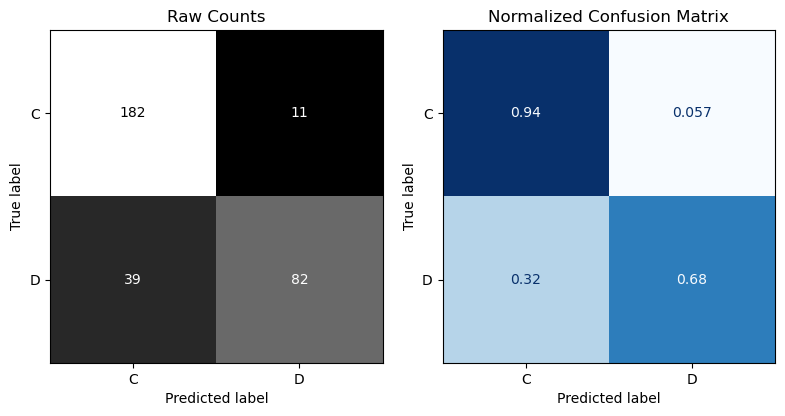

 Classification Metrics: Test Data

              precision    recall  f1-score   support

           C       0.74      0.82      0.78        39
           D       0.81      0.72      0.76        40

    accuracy                           0.77        79

   macro avg       0.77      0.77      0.77        79

weighted avg       0.78      0.77      0.77        79

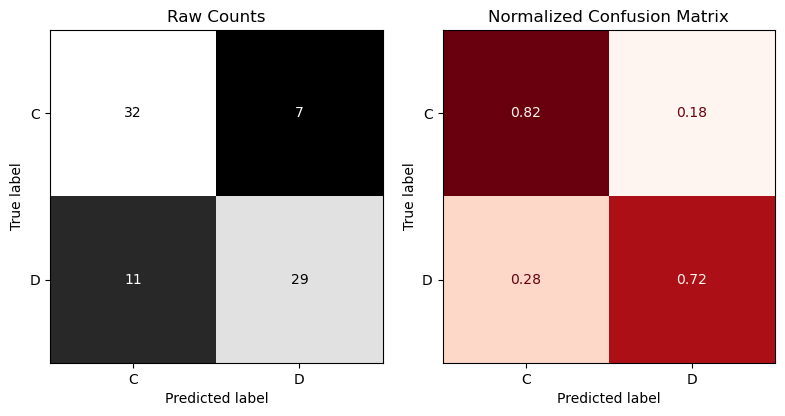

In [6]:
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## Task

In [7]:
# Choose at least one feature engineering method to apply to the data and compare the models’  performance with and without engineering.
  # -- PCA

## Feature Extraction

In [8]:
# Apply PCA to get 3 principal components for the data. Concatenate/combine these PC’s with the original features (X_train, X_test data).


Apply PCA to get 3 principal components for the data. Concatenate/combine these PC’s with the original features (X_train, X_test data).
  * ​Remember to only fit the PCA on the training data and use pca.transform(X_test) to get the PCs for the testing data.

#### Clean the Data

In [9]:
df = df.loc[df['Status'] != 'CL']
df = df.drop(columns=['ID'])
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0


#### train/test split

In [10]:
X = df.drop(columns='Status')
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
349,662,NaN,17532,F,NaN,NaN,NaN,N,2.1,NaN,4.10,NaN,NaN,NaN,NaN,200.0,9.0,3.0
189,2504,D-penicillamine,19916,F,N,N,Y,N,2.3,NaN,3.93,24.0,1828.0,133.30,NaN,327.0,10.2,2.0
178,2573,Placebo,16050,F,N,Y,N,N,1.8,396.0,3.83,39.0,2148.0,102.30,133.0,278.0,9.9,4.0
64,3992,D-penicillamine,14684,F,N,N,N,N,1.2,256.0,3.60,74.0,724.0,141.05,108.0,430.0,10.0,1.0
363,359,NaN,21550,F,NaN,NaN,NaN,N,2.7,NaN,3.35,NaN,NaN,NaN,NaN,142.0,11.5,4.0


### Pipelines

In [11]:
mean_imputer = SimpleImputer(strategy='mean')
ohe = OneHotEncoder(drop='first', sparse_output=False)
scaler = StandardScaler()

ohe_cols = X_train.select_dtypes('object').columns.tolist()
num_cols = X_train.select_dtypes('number').columns.tolist()

ohe_cols, num_cols

(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'],
 ['N_Days',
  'Age',
  'Bilirubin',
  'Cholesterol',
  'Albumin',
  'Copper',
  'Alk_Phos',
  'SGOT',
  'Tryglicerides',
  'Platelets',
  'Prothrombin',
  'Stage'])

In [12]:
constant_imputer = SimpleImputer(strategy='constant', fill_value='NA')

In [13]:
ohe_pipe = make_pipeline(constant_imputer, ohe)
num_pipe = make_pipeline(mean_imputer, scaler)

ohe_tuple = ('ohe', ohe_pipe, ohe_cols)
num_tuple = ('num', num_pipe, num_cols)

In [14]:
transformer = ColumnTransformer([ohe_tuple, num_tuple], verbose_feature_names_out=False)
transformer

ColumnTransformer(transformers=[('ohe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                  'Spiders', 'Edema']),
                                ('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['N_Days', 'Age', 'Bilirubin', 'Cholesterol',
                                  'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                                  'Tryglicerides', 'Platelets', 'Prothrombin',
                                  'Stage'])],
                  verbose_feature_names_out=False)

In [15]:
transformer.fit(X_train)

ColumnTransformer(transformers=[('ohe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                  'Spiders', 'Edema']),
                                ('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['N_Days', 'Age', 'Bilirubin', 'Cholesterol',
                                  'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                                  'Tryglicerides', 'Platelets', 'Prothrombin',
                                  'Stage'])],
                  verbose_feature_names_out=False)

In [16]:
X_train_tf = transformer.transform(X_train)
X_test_tf = transformer.transform(X_test)
X_train_tf

,Drug_NA,Drug_Placebo,Sex_M,Ascites_NA,Ascites_Y,Hepatomegaly_NA,Hepatomegaly_Y,Spiders_NA,Spiders_Y,Edema_S,Edema_Y,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
349,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1.177240,-0.308746,-0.193907,-3.444534e-16,1.413612,0.000000,-2.546643e-16,0.000000,-2.936551e-16,-0.593780,-1.640318,0.021837
189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.486860,0.307956,-0.146451,-3.444534e-16,1.009398,-0.928710,-5.454328e-02,0.248853,-2.936551e-16,0.713139,-0.506524,-1.099139
178,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.549196,-0.692115,-0.265092,2.155229e-01,0.771625,-0.720844,1.246608e-01,-0.357647,2.325709e-01,0.208894,-0.789973,1.142813
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.831150,-1.045477,-0.407462,-6.328335e-01,0.224748,-0.235825,-6.727972e-01,0.400478,-2.840326e-01,1.773081,-0.695490,-2.220115
363,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1.450977,0.730646,-0.051537,-3.444534e-16,-0.369684,0.000000,-2.546643e-16,0.000000,-2.936551e-16,-1.190641,0.721752,1.142813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.010027,-1.206896,-0.526104,-1.384235e+00,0.224748,-1.025714,-8.413610e-01,-1.388697,-1.358568e+00,0.075115,0.249338,-2.220115
108,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.486860,-0.680733,-0.573561,-1.456951e+00,0.248525,-0.526837,-6.279962e-01,-0.206022,-1.441224e+00,0.136860,-0.128593,0.021837
285,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.503289,-1.173008,-0.217636,-3.056103e-01,-0.345906,-0.291256,-3.743105e-01,0.027774,-7.739118e-02,-1.180350,-0.884455,0.021837
370,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.333532,-0.025228,1.039966,-3.444534e-16,0.034530,0.000000,-2.546643e-16,0.000000,-2.936551e-16,0.075115,0.343821,-2.220115


### KNN Model

In [17]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier()

In [45]:
knn.n_features_in_

17

In [19]:
%%time
preds = knn.predict(X_test_tf)

CPU times: total: 578 ms
Wall time: 235 ms


## PCA

In [20]:
%%time

pca = PCA(n_components=3)
knn_pca_pipe = make_pipeline(SimpleImputer(strategy='median'), scaler, pca, knn)



CPU times: total: 500 ms
Wall time: 178 ms


In [48]:
def apply_pca(X_train, X_test):
  pca = PCA(n_components=3)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)

  return np.concatenate((X_train, X_train_pca), axis=1), np.concatenate((X_test, X_test_pca), axis=1)

X_train_combined, X_test_combined = apply_pca(X_train_tf, X_test_tf)

knn_pca_pipe.fit(X_train_combined, y_train)

# Apply at least one method of feature selection (filtering, embedded, wrapper) to your new features including engineered data


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier())])

## Model 2

In [69]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier

# Instantiate the model
dt = DecisionTreeClassifier(random_state = 42)

# Instantiate the SequentialFeatureSelector
sfs = SequentialFeatureSelector(dt, n_features_to_select=.95,
                                direction = 'forward', cv=2,
                                 n_jobs=-1)
sfs.fit(X_train_tf, y_train)

SequentialFeatureSelector(cv=2,
                          estimator=DecisionTreeClassifier(random_state=42),
                          n_features_to_select=0.95, n_jobs=-1)

In [71]:
# sfs.support_
len(sfs.support_)

23

In [72]:
# .support_ returns an array of T/F whether it is above threshold
features_to_keep = sfs.support_
# Only include the features selected
X_train_23 = X_train_tf.loc[:,features_to_keep]
X_test_23 = X_test_tf.loc[:,features_to_keep]
X_train_23.shape


(314, 21)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       193
           D       1.00      1.00      1.00       121

    accuracy                           1.00       314
   macro avg       1.00      1.00      1.00       314
weighted avg       1.00      1.00      1.00       314



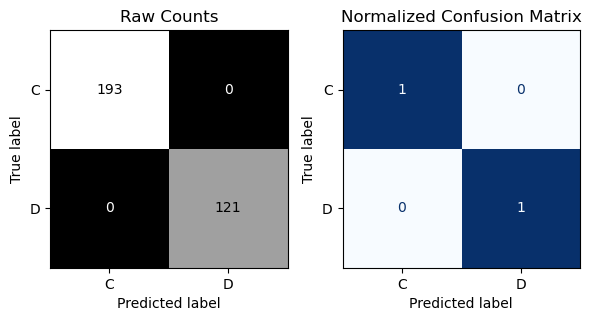


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.79      0.85      0.81        39
           D       0.84      0.78      0.81        40

    accuracy                           0.81        79
   macro avg       0.81      0.81      0.81        79
weighted avg       0.81      0.81      0.81        79



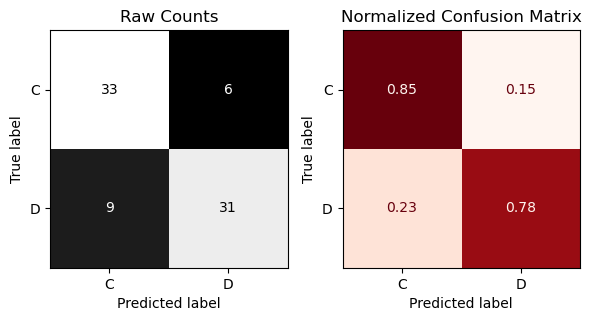

In [73]:
# Instantiate default random forest
rf_clf = RandomForestClassifier(random_state=42)
# Fit on 39 selected featuers
rf_clf.fit(X_train_23, y_train)
# Evaluate with custom function
evaluate_classification(rf_clf, X_train_23, y_train, X_test_23, y_test)

## Insights

 Classification Metrics: Test Data - Original Model

              precision    recall  f1-score   support

           C       0.74      0.82      0.78        39
           D       0.81      0.72      0.76        40

    accuracy                           0.77        79

   macro avg       0.77      0.77      0.77        79

weighted avg       0.78      0.77      0.77        79

----------------------------------------------------------------------
 Classification Metrics: Test Data - New model
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.79      0.85      0.81        39
           D       0.84      0.78      0.81        40

    accuracy                           0.81        79
   macro avg       0.81      0.81      0.81        79
weighted avg       0.81      0.81      0.81        79


In [93]:
# Extract and visualize the top 10 features using permutation importance from X_train_23
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_clf, X_train_23, y_train, n_repeats=10,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()[-10:]

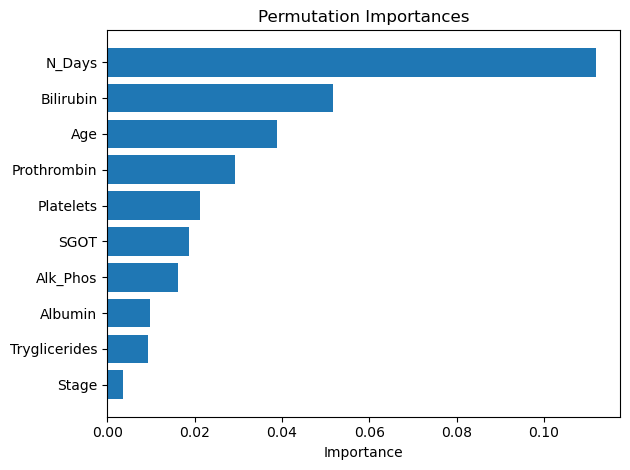

In [101]:
fig, ax = plt.subplots()
ax.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels(X_train_23.columns[sorted_idx])
ax.set_xlabel('Importance')
ax.set_title('Permutation Importances')
fig.tight_layout()
plt.show()

From Part 1:

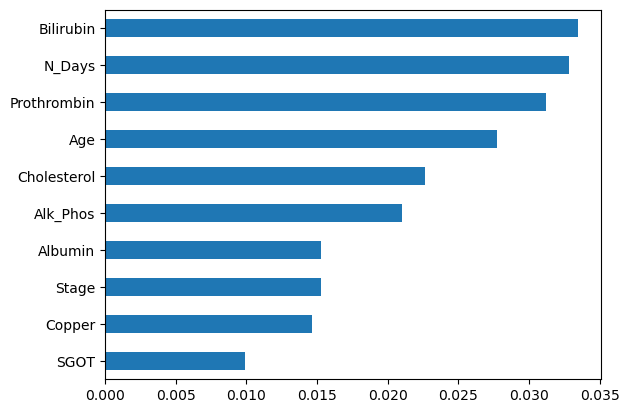

In [ ]:
# In a Markdown cell, comment on how these features compare to the model from Part 1. Are there any new features in the top 10?

Two new features made the top 10:

* Triglycerides
* Platelets

Additionally, several of the features changed positions in the top ten, and the gap between N_Days at number 1 and the rest of the features grew significantly